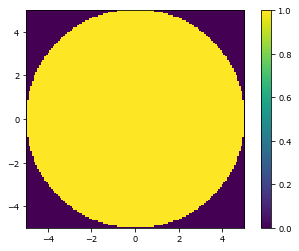

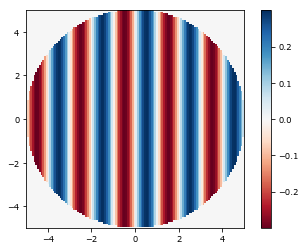

In [5]:
from hcipy import *
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

N = 128
padding = 1 # zero-padding on pyramid output. 1 means sub-pupil images touch the outside edges

D_keck = 9.96
keck_aperture = circular_aperture(D_keck) 
# I also implemented a better make_keck_aperture, this is just for simplicity when testing
pupil_grid = make_pupil_grid(N, D_keck * padding)

wf = Wavefront(keck_aperture(pupil_grid))

aberrated = wf.copy()
amplitude = 0.3
spatial_frequency = 5
aberrated.electric_field *= np.exp(1j * amplitude * np.sin(2*np.pi * pupil_grid.x / D_keck * spatial_frequency))

imshow_field(wf.intensity)
plt.colorbar()
plt.show()

imshow_field(aberrated.phase, cmap='RdBu')
plt.colorbar()
plt.show()

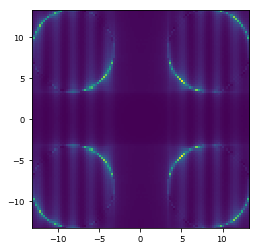

In [6]:
sps = 40 #sub-pupil size
pupsep = 65/39.3
outgrid_size = int(np.ceil(sps * (pupsep + 1)))
keck_pyramid = PyramidWavefrontSensorOptics(pupil_grid, pupil_separation=pupsep, num_pupil_pixels=sps)
pyramid_grid = make_pupil_grid(N, 3.6e-3)
pyramid_output = keck_pyramid.forward(aberrated).intensity
imshow_field(pyramid_output)
plt.show()

In [7]:
def get_sub_images(pyramid_output, N):
    outgrid = np.zeros((N, N)).tolist()
    pyramid_output.shape = (outgrid_size, outgrid_size)
    buffer = (N - outgrid_size)//2
    # added ability to get sub-pupil images that are separated. Default PWFSOptics has pupil separation = 1.5 but 
    # image extraction assumes separation = 1. Not sure, but this may have caused errors before.
    for rownum, row in enumerate(pyramid_output.tolist()):
        for colnum, el in enumerate(row):
            outgrid[rownum+buffer][colnum+buffer] = el
    images = Field(np.asarray(outgrid).ravel(), pyramid_grid)
    image = images.shaped
    sub_images = [image[buffer:sps+buffer, buffer:sps+buffer], 
                  image[(N-buffer-sps-1):(N-buffer-1), buffer:sps+buffer],
                  image[buffer:sps+buffer, (N-buffer-sps-1):(N-buffer-1)], 
                  image[(N-buffer-sps-1):(N-buffer-1), (N-buffer-sps-1):(N-buffer-1)]]
    subimage_grid = make_pupil_grid(sps)
    for count, img in enumerate(sub_images):
        img = img.ravel()
        img.grid = subimage_grid
        sub_images[count] = img
    return sub_images
    # This slightly crops some of the edges of the sub-pupil images, but it is the actual size we'll have to work with.
    # Hopefully no significant information loss because of this. (Maybe off by one?)
    
get_sub_images(pyramid_output, N)

[Field([ 0.05155385,  0.06054648,  0.0696145 , ...,  0.16859924,
         0.14842907,  0.1300715 ]),
 Field([ 0.07873166,  0.08772589,  0.09706961, ...,  0.09551875,
         0.09081591,  0.08150067]),
 Field([ 0.07281229,  0.06751705,  0.06669161, ...,  0.06425519,
         0.07321871,  0.07649875]),
 Field([ 0.11917967,  0.11289766,  0.11525986, ...,  0.04915555,
         0.05281682,  0.05155335])]

In [8]:
def estimate(EstimatorObject, images_list):
    '''
    Slightly edited version of the PWFSEstimator.estimate function. The earlier function had a difference in sub-pupil
    numbering compared to the literature I found. As implemented before, it was 
    a b
    c d
    but according to papers such as https://ui.adsabs.harvard.edu/#abs/2006OExpr..1411925B/abstract (page 3) it's
    b a
    c d
    '''
    I_b = images_list[0]
    I_a = images_list[1]
    I_c = images_list[2]
    I_d = images_list[3]
    norm = I_a + I_b + I_c + I_d
    I_x = (I_a + I_b - I_c - I_d) / norm
    I_y = (I_a - I_b - I_c + I_d) / norm
    dummy = Field(np.zeros(I_x.size), I_x.grid)
    I_x = I_x.ravel()
    I_y = I_y.ravel()
    dummy = dummy.ravel()
    res = Field([I_x, I_y, dummy], EstimatorObject.pupil_mask.grid)
    # previously, was not possible to plot res, can now do so as a red-green plot (red = x and green = y).
    return res, I_x, I_y

pyramid_subgrid = make_pupil_grid(sps*2, (3.6e-3)*sps*2/N)
keck_pyramid_estimator = PyramidWavefrontSensorEstimator(keck_aperture, pyramid_subgrid)
aberratedslopes, x_slopes, y_slopes = estimate(keck_pyramid_estimator, sub_images)
plt.subplot(2,2,1)
imshow_field(x_slopes, cmap='RdBu')
plt.colorbar()
plt.subplot(2,2,2)
imshow_field(y_slopes, cmap='RdBu')
plt.colorbar()
plt.show()

NameError: name 'sub_images' is not defined

In [ ]:
print(x_slopes.shape)

In [ ]:
print(min(x_slopes))

In [ ]:
def makeflatwfslopes():
    flat_pyramid_output = keck_pyramid.forward(wf).intensity
    flat_pyramid_output.shape = (outgrid_size, outgrid_size)
    # added ability to get sub-pupil images that are separated. Default PWFSOptics has pupil separation = 1.5 but 
    # image extraction assumes separation = 1. Not sure, but this may have caused errors before.
    for rownum, row in enumerate(flat_pyramid_output.tolist()):
        for colnum, el in enumerate(row):
            outgrid[rownum+buffer][colnum+buffer] = el
    images = Field(np.asarray(outgrid).ravel(), pyramid_grid)
    image = images.shaped
    flat_sub_images = [image[buffer:sps+buffer, buffer:sps+buffer], 
                  image[(N-buffer-sps-1):(N-buffer-1), buffer:sps+buffer],
                  image[buffer:sps+buffer, (N-buffer-sps-1):(N-buffer-1)], 
                  image[(N-buffer-sps-1):(N-buffer-1), (N-buffer-sps-1):(N-buffer-1)]]
    for count, img in enumerate(flat_sub_images):
        img = img.ravel()
        img.grid = subimage_grid
        flat_sub_images[count] = img
    return estimate(keck_pyramid_estimator, flat_sub_images)

In [ ]:
flat_res, flat_x, flat_y = makeflatwfslopes()
imshow_field(flat_x)
plt.show()
imshow_field(flat_y)
plt.show()

In [ ]:
imshow_field(- flat_x + x_slopes)
plt.colorbar()
plt.show()

In [ ]:
imshow_field(y_slopes - flat_y)
plt.colorbar()
plt.show()

In [ ]:
M = np.array((np.asarray(x_slopes - flat_x), np.asarray(y_slopes - flat_y)))
M_inv = inverse_tikhonov(M, 1e-3)

In [ ]:
from skimage.transform import resize
q = x_slopes - flat_x
q.shape = (sps, sps)
q = resize(q, (N, N))
q = Field(q.ravel(), pupil_grid)
#s = M.dot(x_resized.intensity)
corrected = q + aberrated.phase
imshow_field(corrected)
plt.show()

In [2]:
from hcipy import *
import numpy as np
from matplotlib import pyplot as plt
aberration_mode_basis = []
N = 128
D = 10
aperture = circular_aperture(D)
pupil_grid = make_pupil_grid(N, D)
for i in range(N):
    for j in range(N):
        wf = Wavefront(aperture(pupil_grid))
        wf.electric_field.shape = (N, N)
        l = wf.electric_field.tolist()
        if np.real(l[i][j]) > 0:
            l[i][j] = 0
            wf.electric_field = Field(np.asarray(l).ravel(), wf.grid)
            aberration_mode_basis.append(wf)

In [ ]:
type(aberration_mode_basis[0])

In [4]:
'''
For each pixel on 128x128, check if the aperture is 0, and if it's not then write the pixel value to a new list
'''
wf = Wavefront(keck_aperture(pupil_grid))
aperturelist = aperture(pupil_grid)
aperturelist.shape = (N, N)
aperturelist = aperturelist.tolist()
aberratedlist = aberrated.intensity.copy()
aberratedlist.shape = (N, N)
aberratedlist = aberratedlist.tolist()
aberration_modes = []
for i in range(N):
    for j in range(N):
        if aperturelist[i][j] != 0:
            aberration_modes.append(aberratedlist[i][j])
pyramid_output_basis = []
for index, x in enumerate(aberration_mode_basis):
    if index % 100 == 0:
        print(index)
    pyramid_output_basis.append(keck_pyramid.forward(x))
sub_images_basis = [get_sub_images(x) for x in pyramid_output_basis]

NameError: name 'keck_aperture' is not defined

In [ ]:
imshow_field(pyramid_output_basis[1].intensity, make_pupil_grid(107))
plt.show()

In [ ]:
def new_get_sub_images(intensity):
    buffer = 0
    sps = 40
    images = Field(np.asarray(intensity).ravel(), pyramid_grid)
    images.shape = (107, 107)
    image = images
    sub_images = [image[buffer:sps+buffer, buffer:sps+buffer], 
                  image[(N-buffer-sps-1):(N-buffer-1), buffer:sps+buffer],
                  image[buffer:sps+buffer, (N-buffer-sps-1):(N-buffer-1)], 
                  image[(N-buffer-sps-1):(N-buffer-1), (N-buffer-sps-1):(N-buffer-1)]]
    subimage_grid = make_pupil_grid(sps)
    for count, img in enumerate(sub_images):
        img = img.ravel()
        img.grid = subimage_grid
        sub_images[count] = img
    return sub_images

new_get_sub_images(pyramid_output_basis[1].intensity)

In [ ]:
sub_images_basis = []
for index, x in enumerate(pyramid_output_basis):
    if index % 1000 == 0:
        print(index)
    sub_images_basis.append(new_get_sub_images(x.intensity))

In [ ]:
sub_image_basis = np.asarray(sub_images_basis)
print(sub_image_basis.shape)

In [ ]:
print(sub_images_basis)